In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Vektori riječi


## Logistička regresija: analiza sentimenta

Analiza sentimenta uz pomoć logističke regresije

In [3]:
import nltk
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
# tvitovi
from nltk.corpus import twitter_samples
# pomocne funkcije za obradu tvitova
from utils import process_tweet, build_freqs

In [4]:
# ucitaj skup pozitivnih i negativnih tvitova
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

tweets = all_positive_tweets + all_negative_tweets # spoji liste
positive_labels = np.ones((len(all_positive_tweets),1)) # poz. oznake kao polje 1-ica
negative_labels = np.zeros((len(all_negative_tweets),1)) # neg. oznake kao polje 0
labels = np.append(positive_labels, negative_labels, axis = 0) # sve oznake

# podjela skupa na trening i test
train_pos  = all_positive_tweets[:4000]
test_pos = all_positive_tweets[4000:]
train_neg  = all_negative_tweets[:4000]
test_neg = all_negative_tweets[4000:]

train_x = train_pos + train_neg
train_y = np.append(positive_labels[:4000], negative_labels[:4000], axis=0)

# demo podjele
print(f"train_y.shape = {train_y.shape}")
test_x = test_pos + test_neg
test_y = np.append(positive_labels[4000:], negative_labels[4000:], axis=0)
print(f"test_y.shape = {test_y.shape}")

print("brjo tvitova u trening skupu: ", len(train_x))
print("broj tvitova u test skupu: ", len(test_x))

train_y.shape = (8000, 1)
test_y.shape = (2000, 1)
brjo tvitova u trening skupu:  8000
broj tvitova u test skupu:  2000


In [5]:
# izracunaj frekvencije pojedinih rijeci u + ili - sentimentu
freqs = build_freqs(train_x, train_y)

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))


type(freqs) = <class 'dict'>
len(freqs) = 11337


In [6]:
# testiranje skupa podataka
print('+ tvit: \n', train_x[0])
# potrebno je ocistiti rijeci od suvisnih simobola i tokenzirati, koristiti `utils.process_tweet`
print('\nobradjeni + tvit: \n', process_tweet(train_x[0]))

+ tvit: 
 #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)

obradjeni + tvit: 
 ['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']


In [7]:

# definirajmo znacajke
def extract_features(tweet, freqs):
    tweet_words = process_tweet(tweet)
    # prvi stupac je pristranost, drugi je +broj rijeci, a treci -broj rijeci    
    feature_vector = np.zeros((1, 3))
    feature_vector[0, 0] = 1
    for word in tweet_words:
        feature_vector[0, 1] += freqs.get((word, 1.0), 0)
        feature_vector[0, 2] += freqs.get((word, 0.0), 0)
    return feature_vector

In [8]:
# provjeri kako smo izvukli znacajke iz primjera
test_features = extract_features(train_x[0], freqs)
test_features

array([[1.00e+00, 3.02e+03, 6.10e+01]])

In [9]:
# izvlacenje znacajki za trening i test
train_X = np.zeros((len(train_x), 3))
test_X = np.zeros((len(test_x), 3))

for i, tweet in enumerate(train_x):
    train_X[i, :] = extract_features(tweet, freqs)
for i, tweet in enumerate(test_x):
    test_X[i, :] = extract_features(tweet, freqs)

print(train_X.shape)
print(test_X.shape)

(8000, 3)
(2000, 3)


In [10]:
# iskoristi logisticku regresiju iz scikit-learn paketa
from sklearn.linear_model import LogisticRegression
sentiment_model = LogisticRegression()
# treniraj model
sentiment_model.fit(train_X, train_y.ravel())
# iscitaj koeficijente
theta = sentiment_model.coef_[0]
theta

LogisticRegression()

array([ 0.49631596,  0.00903952, -0.01025998])

In [11]:
# testiraj trenirani model na testnom primjeru
sample_pos_tweet = train_x[0]
sample_neg_tweet = train_x[5001]
test_tweet1 = test_x[1005]

def predict_tweet_sentiment(tweet, label):
    print(f"\nTweet = {tweet}")    
    tweet_input_features = extract_features(tweet, freqs)
    scores = sentiment_model.decision_function(tweet_input_features)
    print(f"z = {scores[0]}")
    predicted_sentiment = sentiment_model.predict(tweet_input_features)
    predicted_sentiment = predicted_sentiment[0]
    print(f"predvidjeni sentiment = {predicted_sentiment}")
    predict_probab = sentiment_model.predict_proba(tweet_input_features)
    print(f"predvidjena vjerojatnost = {predict_probab[:, 1][0]}")
    if predicted_sentiment == 1:
        print(f'+ sentiment. Stvarno = {label[0]}')
    elif predicted_sentiment == 0 :
        print(f'- sentiment. Stvarno = {label[0]}')

predict_tweet_sentiment(sample_pos_tweet, train_y[0])
predict_tweet_sentiment(sample_neg_tweet, train_y[5001])
predict_tweet_sentiment(test_tweet1, test_y[1005])



Tweet = #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
z = 27.666186593222264
predvidjeni sentiment = 1.0
predvidjena vjerojatnost = 0.9999999999990346
+ sentiment. Stvarno = 1.0

Tweet = Saturday Classes! :(
z = -36.71102038810298
predvidjeni sentiment = 0.0
predvidjena vjerojatnost = 1.1392169037187492e-16
- sentiment. Stvarno = 0.0

Tweet = It's really hot :-(
z = -3.257307236273272
predvidjeni sentiment = 0.0
predvidjena vjerojatnost = 0.037065198005719495
- sentiment. Stvarno = 0.0


In [12]:
# izracunaj tocnost predikcije
def get_prediction_accuracy(predicted_labels, true_labels):    
    # izracun tocno predvidjenih testnih primjera
    is_correct = predicted_labels == true_labels    
    #  izracun tocnosti
    accuracy = len(predicted_labels[is_correct]) / len(is_correct)    
    return round(accuracy, 2), is_correct

test_predicted_labels = sentiment_model.predict(test_X)
accuracy, is_correct = get_prediction_accuracy(test_predicted_labels, test_y.ravel())
sklearn_accuracy = sentiment_model.score(test_X, test_y)
print(f"Tocnost predikcije log. regresije za sentiment = {accuracy}") 
print(f"Tocnost predikcije log. regresije za sentiment (sklearn mjera) = {sklearn_accuracy}")

Tocnost predikcije log. regresije za sentiment = 0.99
Tocnost predikcije log. regresije za sentiment (sklearn mjera) = 0.9915


In [ ]:
# Error analysis
test_x = np.array(test_x)
mispredicted_tweets = test_x[~is_correct]
print(f"Number of misclassified tweets = {len(mispredicted_tweets)}")
test_tweets = np.concatenate((test_x.reshape(-1, 1), test_predicted_labels.reshape(-1, 1), test_y.reshape(-1, 1)), 
                            axis=1)
df_test_tweets = pd.DataFrame({'Tweet': pd.Series(test_x, dtype='str'),
                               'Predicted_Label': pd.Series(test_predicted_labels, dtype='float'),
                               'True_Label': pd.Series(test_y.ravel(), dtype='float')})                            
print(test_tweets.shape)
df_test_tweets.head()   

In [72]:
# krivo prediktiran tvitovi
df_misclassified_tweets = df_test_tweets[~is_correct]
df_misclassified_tweets.head()

,Tweet,Predicted_Label,True_Label
84,@MarkBreech Not sure it would be good thing 4 ...,0.0,1.0
129,I'm playing Brain Dots : ) #BrainDots\nhttp://...,0.0,1.0
136,I'm playing Brain Dots : ) #BrainDots http://t...,0.0,1.0
530,I'm playing Brain Dots : ) #BrainDots http://t...,0.0,1.0
822,@msarosh Uff Itna Miss karhy thy ap :p,0.0,1.0


# Vektori riječi: Word2Vec 

In [2]:
%pip install gensim


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: C:\Users\Domagoj\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.0 MB 2.0 MB/s eta 0:00:12
   ---------------------------------------- 0.3/24.0 MB 4.5 MB/s eta 0:00:06
   - -------------------------------------- 0.7/24.0 MB 6.1 MB/s eta 0:00:04
   - -------------------------------------- 1.0/24.0 MB 7.4 MB/s eta 0:00:04
   - -------------------------------------- 1.0/24.0 MB 7.4 MB/s eta 0:00:04
   - -------------------------------------- 1.1/24.0 MB 4.6 MB/s eta 0:00:06
   -- ------------------------------------- 1.6/24.0 MB 5.6 MB/s eta 0:00:04
   --- ------------------------------------ 2.1/24.0 MB 6.3 MB/s eta 0:00:04
   ---- ----------------------------------- 2.6/24.0 MB 7.1 MB/s eta 0:00:04
   ---- ----------------------------------- 3.0/24.0 MB 7.3 MB/s eta 0:00:03
   ------ --------------------------------- 3.6/24.0 MB 8.0 MB/s eta 0:00:03
   ------- -------------------------------- 4.2/24.0 MB 8.4 MB/s eta 0:00:03
   --

U ovoj dijelu demonstrirat ćemo funkcionalnost vektora riječi.

In [3]:
# Get the interactive Tools for Matplotlib
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#!pip install gensim==3.8.3
import gensim

from sklearn.decomposition import PCA

## 1. Gutenberg korpus

In [7]:
import nltk
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Domagoj\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\gutenberg.zip.


True

Projekt Gutenberg je volonterski trud digitalizacije i arhiviranja kulturnih dobara . Većina tekstova u kolekciji su puni tekstovi iz javno dostupnih knjiga.


In [8]:
from nltk.corpus import gutenberg


In [9]:
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

Odaberimo King James Bible kao tekst.

In [10]:
bible_kjv_sents = gutenberg.sents('bible-kjv.txt')
len(bible_kjv_sents)

30103

## 2. Primjena Word2Vec

Normalizacija i čišćenje teksta.

In [11]:
from string import punctuation

dataset = [[word.lower() for word in sent if word not in punctuation and word.isalpha()] 
                                            for sent in bible_kjv_sents]
# primjer nekih
dataset[3]

['in',
 'the',
 'beginning',
 'god',
 'created',
 'the',
 'heaven',
 'and',
 'the',
 'earth']

Word2Vec arhitekturu ćemo iskoristiti iz GenSim paketa.

In [26]:
from gensim.models import Word2Vec

# Define the model
model = Word2Vec(dataset, min_count=2, vector_size=300)

# Get the vocabulary dictionary
vocab_dict = model.wv.key_to_index

# word vectors
word_vectors = model.wv

word = "god"
# vektor riječi za "god"
word_vectors[word]

# koliko puta se pojavila rijec "god"
model.wv.get_vecattr(word, "count")




4472

In [30]:
# Get the most similar words to "god"
most_similar_words = model.wv.most_similar("god")

most_similar_words

[('lord', 0.8022905588150024),
 ('truth', 0.7770713567733765),
 ('spirit', 0.7379916310310364),
 ('salvation', 0.7183221578598022),
 ('hosts', 0.7078943252563477),
 ('christ', 0.6971784234046936),
 ('glory', 0.6962580680847168),
 ('faith', 0.6762832999229431),
 ('gospel', 0.6596940159797668),
 ('mercy', 0.659238338470459)]

In [38]:
word_vectors.most_similar(['heaven'], topn=3)

[('heavens', 0.7321428060531616),
 ('earth', 0.7169708013534546),
 ('palestina', 0.6708223819732666)]

In [31]:
word_vectors.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

[('queen', 0.676397442817688)]

In [32]:
# ponderirana cos slicnost
word_vectors.most_similar_cosmul(positive=['woman', 'king'], negative=['man'], topn=1)

[('queen', 1.0101133584976196)]

In [33]:
word_vectors.similarity('lord', 'god')

0.8022905

In [34]:
word_vectors.doesnt_match("lord god salvation food spirit".split())

'food'

In [54]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def display_pca_scatterplot(model, words=None, sample=0):
    if isinstance(words, int):
        words = np.random.choice(list(model.key_to_index), words) if words > 0 else list(model.key_to_index)
    elif words is None:
        words = list(model.key_to_index)
    word_vectors = np.array([model[word] for word in words])
    points = PCA().fit_transform(word_vectors)[:, :2]
    plt.figure(figsize=(12, 12))
    plt.scatter(points[:, 0], points[:, 1], edgecolors='k', c='r')
    for word, (x, y) in zip(words, points):
        plt.text(x + 0.05, y + 0.05, word)


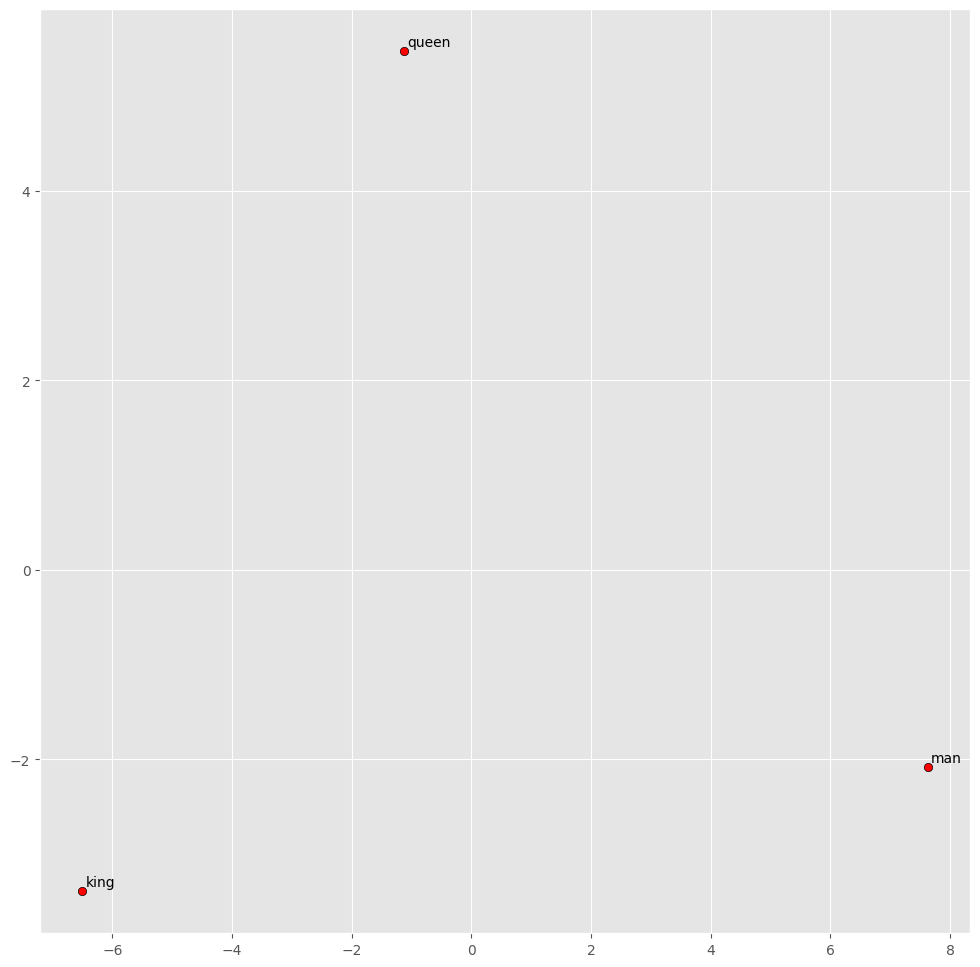

In [55]:
display_pca_scatterplot(word_vectors, words = ['queen', 'king','man'])

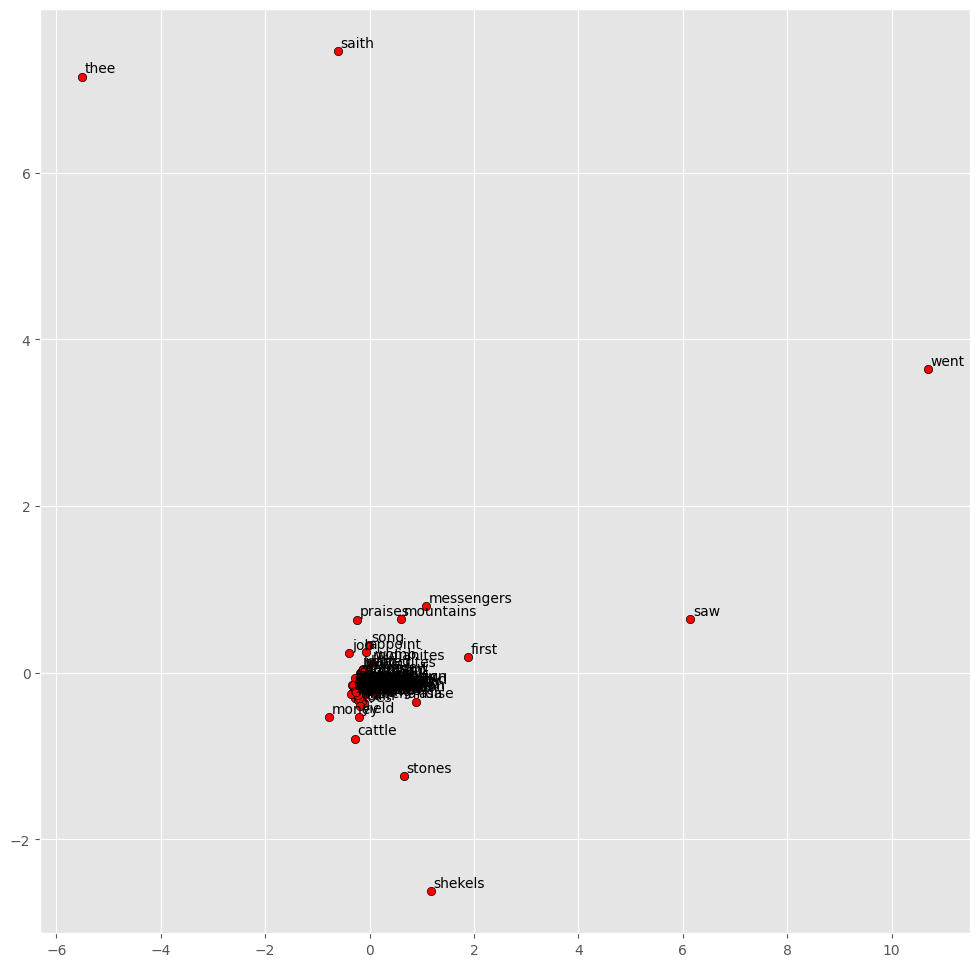

In [57]:
display_pca_scatterplot(word_vectors, words = 100)